##1. Exploratory Data Analysis (EDA)

#Load and inspect the data for basic properties (data types, missing values, duplicates).

In [124]:
import pandas as pd

df = pd.read_csv('sensor_data.csv')
df.head()

,timestamp,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
0,08-01-19 14:41,18.55,0.100,29.05,0.092,18.85,0.128
1,08-01-19 14:41,18.55,0.100,29.25,0.092,18.85,0.132
2,08-01-19 14:41,18.65,0.112,29.05,0.114,18.85,0.132
3,08-01-19 14:41,18.65,0.112,29.25,0.114,18.85,0.110
4,08-01-19 14:41,18.65,0.162,29.05,0.100,18.85,0.110


In [125]:
df.dtypes

,0
timestamp,object
x_axis_temperature,float64
x_axis_vibration,float64
y_axis_temperature,float64
y_axis_vibration,float64
z_axis_temperature,float64
z_axis_vibration,float64


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   timestamp           1048575 non-null  object 
 1   x_axis_temperature  851967 non-null   float64
 2   x_axis_vibration    851967 non-null   float64
 3   y_axis_temperature  851967 non-null   float64
 4   y_axis_vibration    851967 non-null   float64
 5   z_axis_temperature  851967 non-null   float64
 6   z_axis_vibration    851967 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.0+ MB


In [127]:
missing_values = df.isnull().sum()
print(missing_values)

timestamp                  0
x_axis_temperature    196608
x_axis_vibration      196608
y_axis_temperature    196608
y_axis_vibration      196608
z_axis_temperature    196608
z_axis_vibration      196608
dtype: int64


Even though there are no missing rows in timestamp columns others have equal and a significant number of missing rows.

In [128]:
df.describe()

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
count,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000
mean,36.867385,1.014780,19.006035,0.139452,17.708302,0.116789
std,176.659111,7.432032,3.899055,0.254899,2.568081,0.026727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
50%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
75%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
max,1638.350000,65.535000,31.750000,23.732000,22.850000,1.160000


checking rows for duplicates would take too long and wouldn't generate an useful insight for the dataset

#Visualize the behavior of each sensor over time to identify trends, seasonality, or abrupt changes.

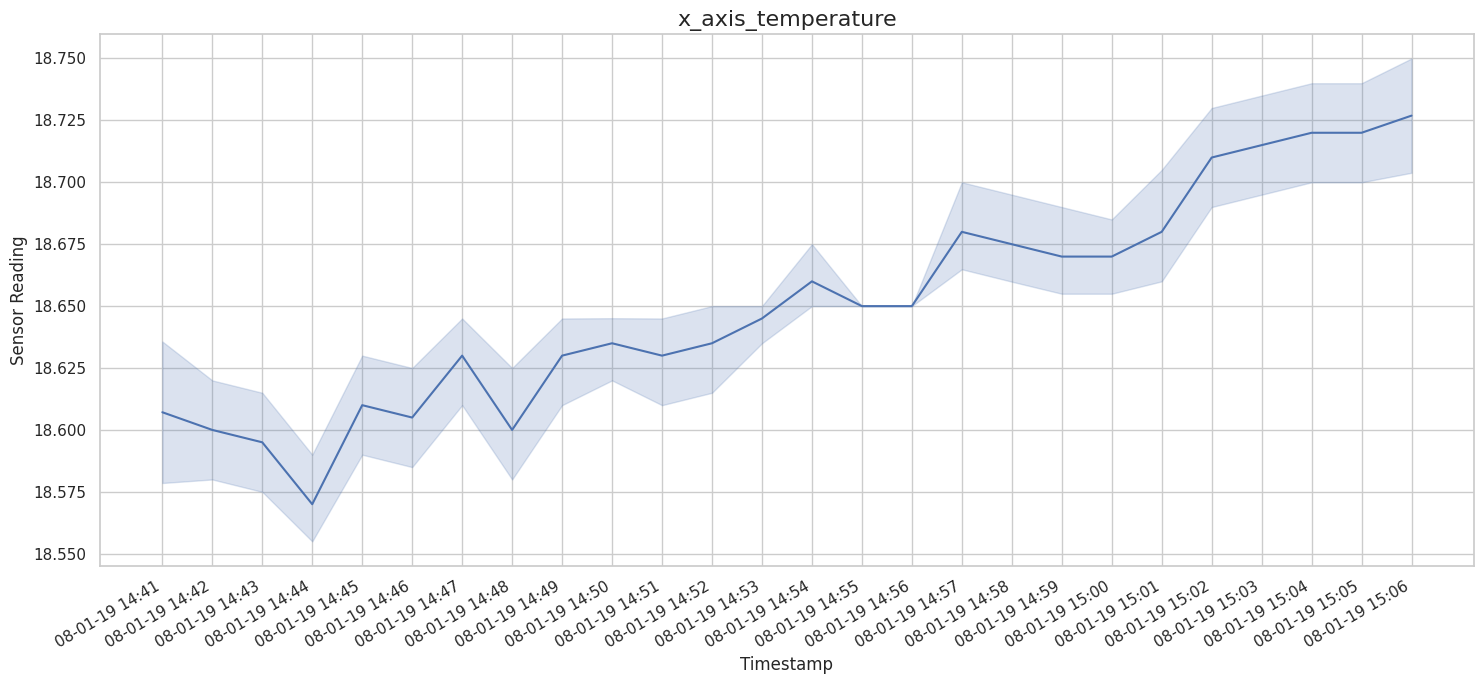

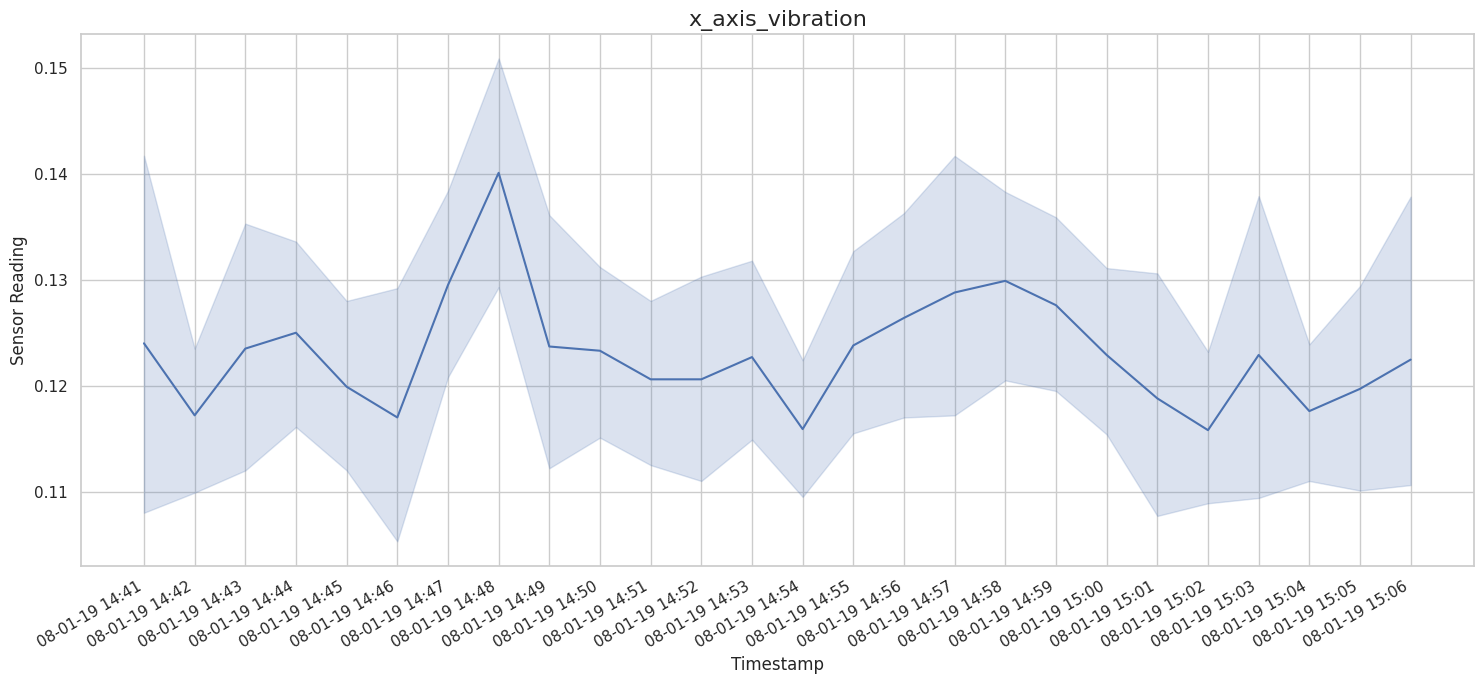

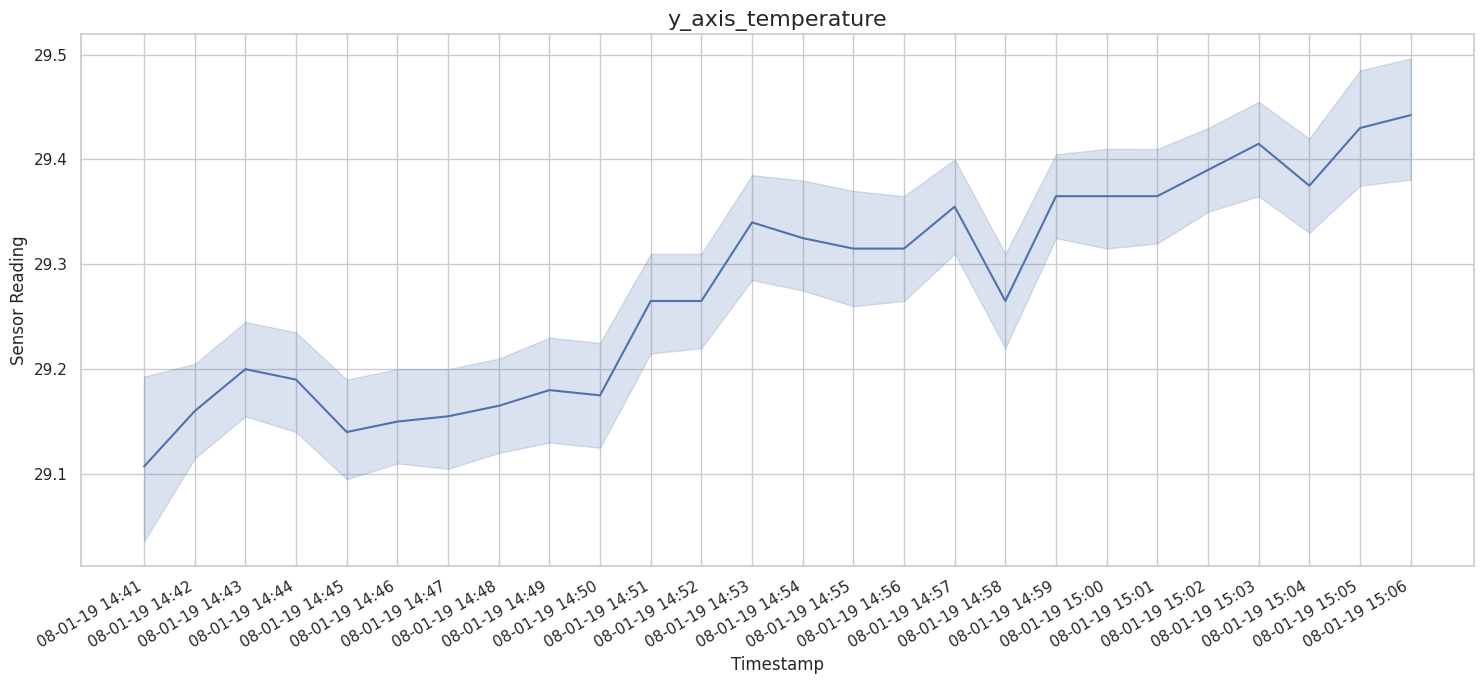

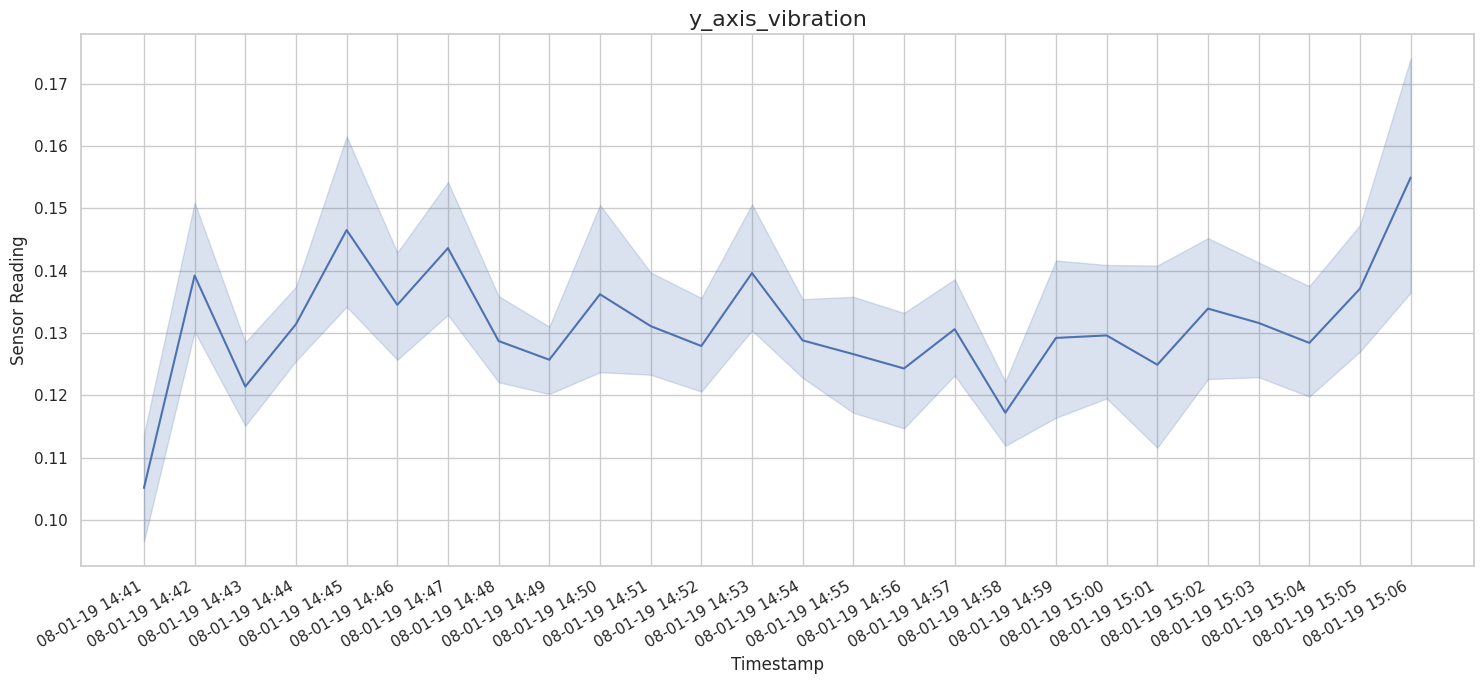

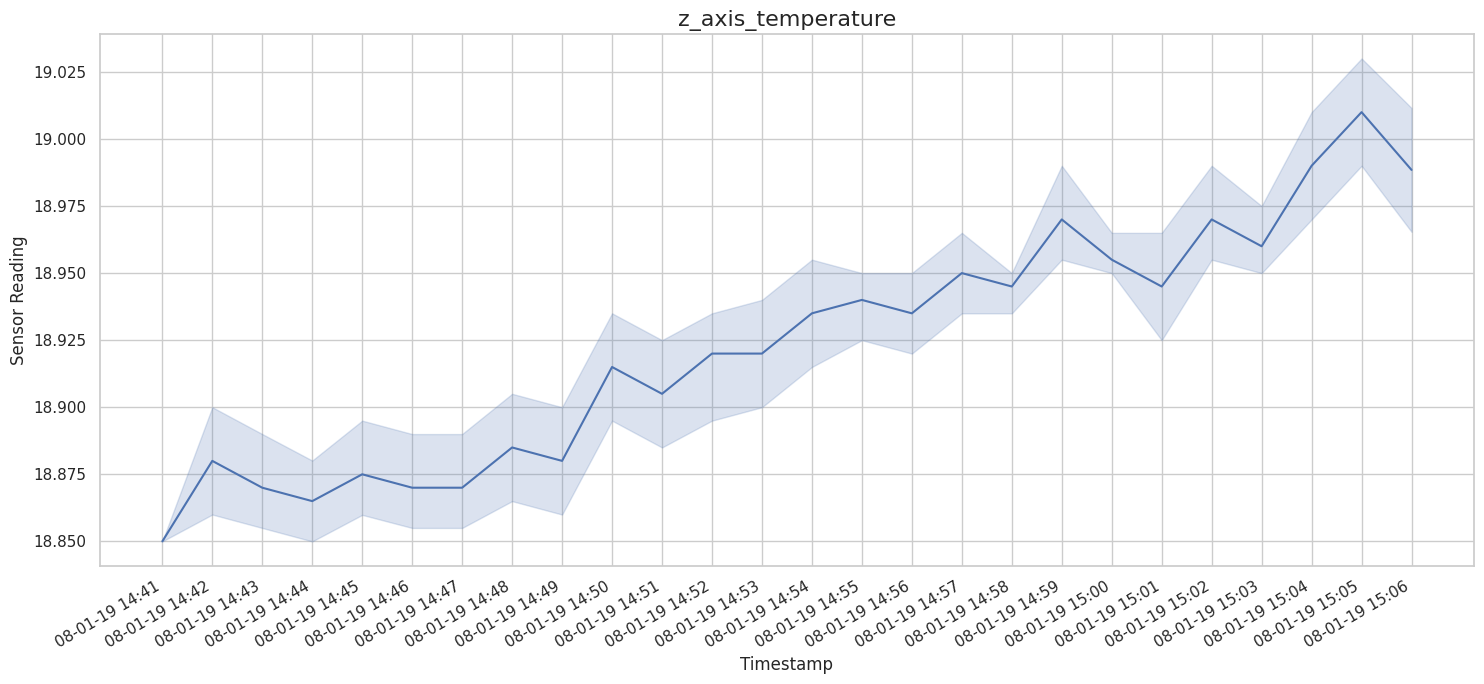

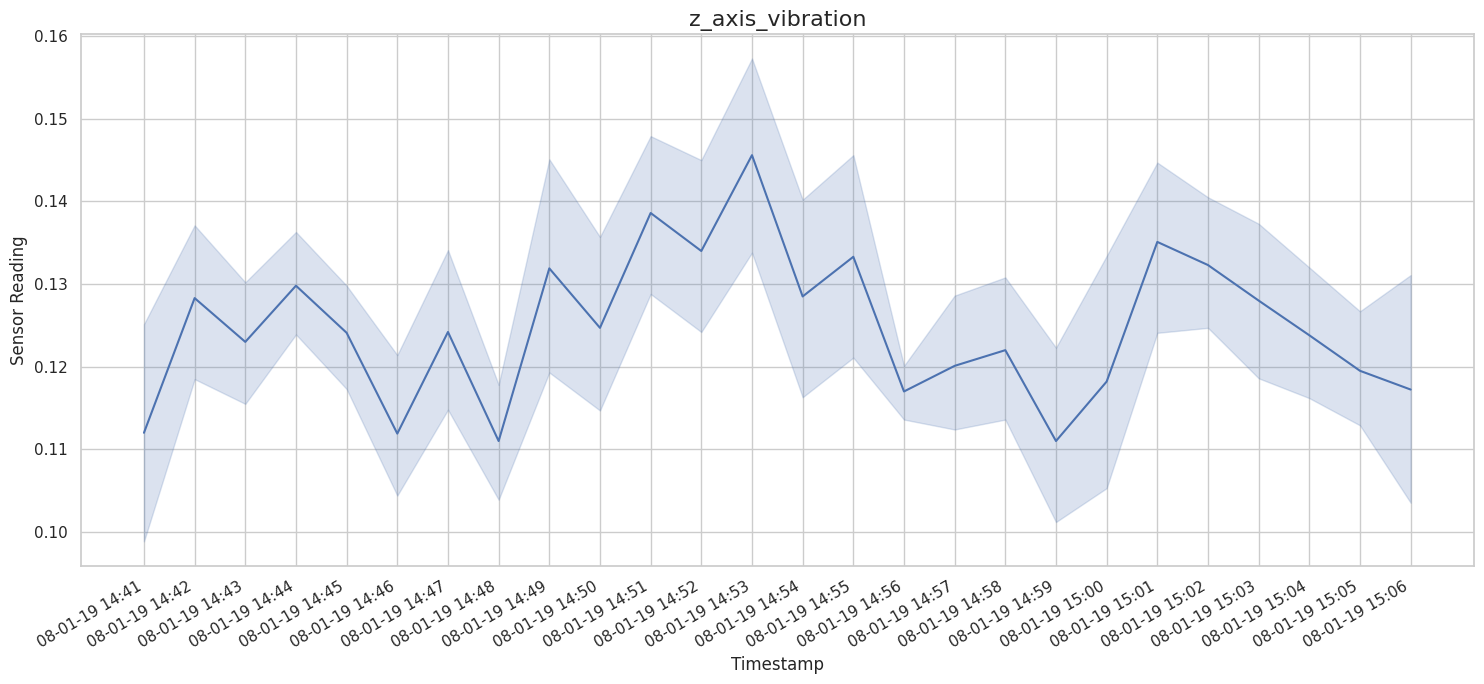

In [129]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):

    sensor_cols_to_plot = df.select_dtypes(include=np.number).columns.tolist()

    sns.set_theme(style="whitegrid")

    for sensor in sensor_cols_to_plot:
        # Create a new figure for each plot to keep them separate
        plt.figure(figsize=(15, 7))

        # Create the line plot
        ax = sns.lineplot(
            x='timestamp',
            y=sensor,
            data=df
        )

        # Set titles and labels
        ax.set_title(f'{sensor}', fontsize=16)
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Sensor Reading', fontsize=12)

        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.show()


df = df.dropna()

plot_data(df[0:500])

Looking at the graphs it is clear that all temperature values tend to increase over time but vibration values are more stable throughout the whole dataset.

#Analyze the distributions of sensor readings to understand their typical ranges and identify potential outliers.

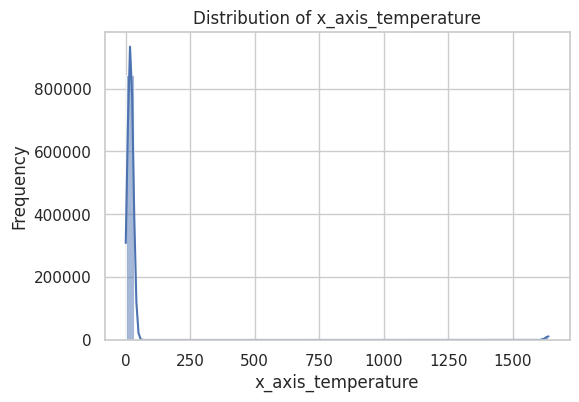

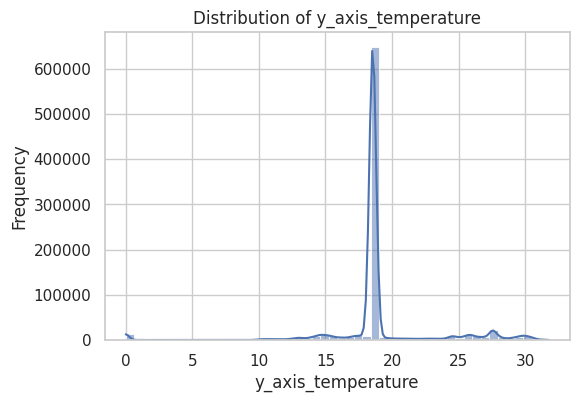

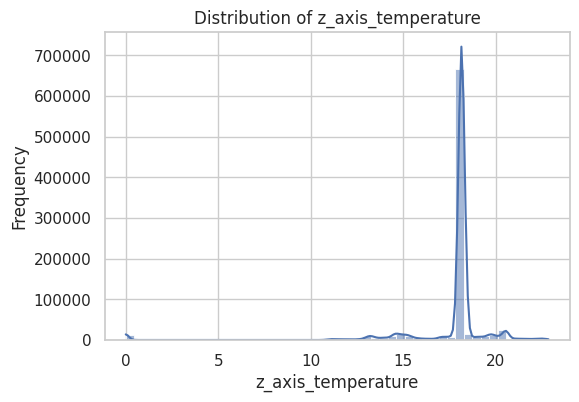

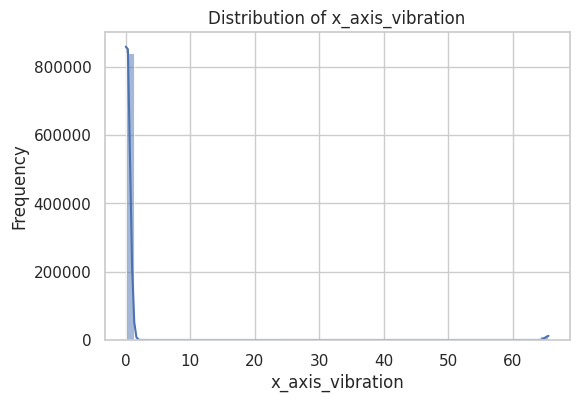

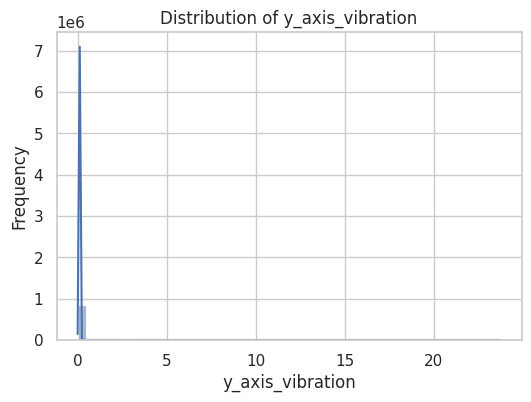

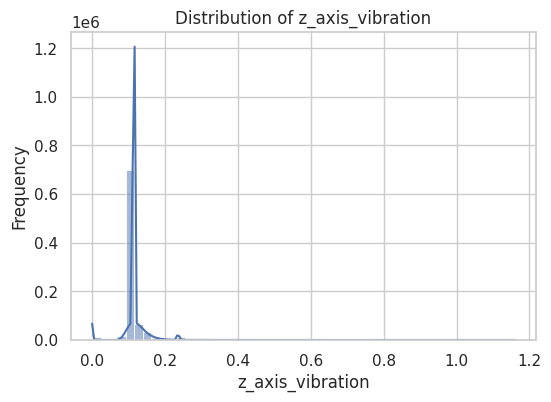

In [130]:
sensor_columns = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", 'x_axis_vibration', 'y_axis_vibration', 'z_axis_vibration']

# Histograms
for col in sensor_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)  # kde=True adds smooth density curve
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

Now moving onto the outlier detection using IsolationForest.

In [131]:
from sklearn.ensemble import IsolationForest

sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]
X = df[sensor_cols]

# Model
iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
df["outlier"] = iso.fit_predict(X)

# outlier=-1 --> anormal, 1 --> normal
outliers = df[df["outlier"] == -1]
print("Outlier count:", len(outliers))

Outlier count: 2414


In [132]:
def show_stats(df, cols, label):
    print(f"\n--- {label} ---")
    print(df[cols].describe(percentiles=[0.01,0.05,0.95,0.99]))


# Initial dataset
show_stats(df, sensor_cols, "Whole data set")

# After removing outliers
clean_df = df[df["outlier"] == 1]
show_stats(clean_df, sensor_cols, "After removing outliers")


--- Whole data set ---
       x_axis_temperature  y_axis_temperature  z_axis_temperature  \
count       851967.000000       851967.000000       851967.000000   
mean            36.867385           19.006035           17.708302   
std            176.659111            3.899055            2.568081   
min              0.000000            0.000000            0.000000   
1%               0.000000            0.000000            0.000000   
5%              14.050000           14.750000           14.350000   
50%             17.650000           18.550000           18.150000   
95%             21.650000           27.550000           19.950000   
99%           1638.350000           30.050000           21.550000   
max           1638.350000           31.750000           22.850000   

       x_axis_vibration  y_axis_vibration  z_axis_vibration  
count     851967.000000     851967.000000     851967.000000  
mean           1.014780          0.139452          0.116789  
std            7.432032       

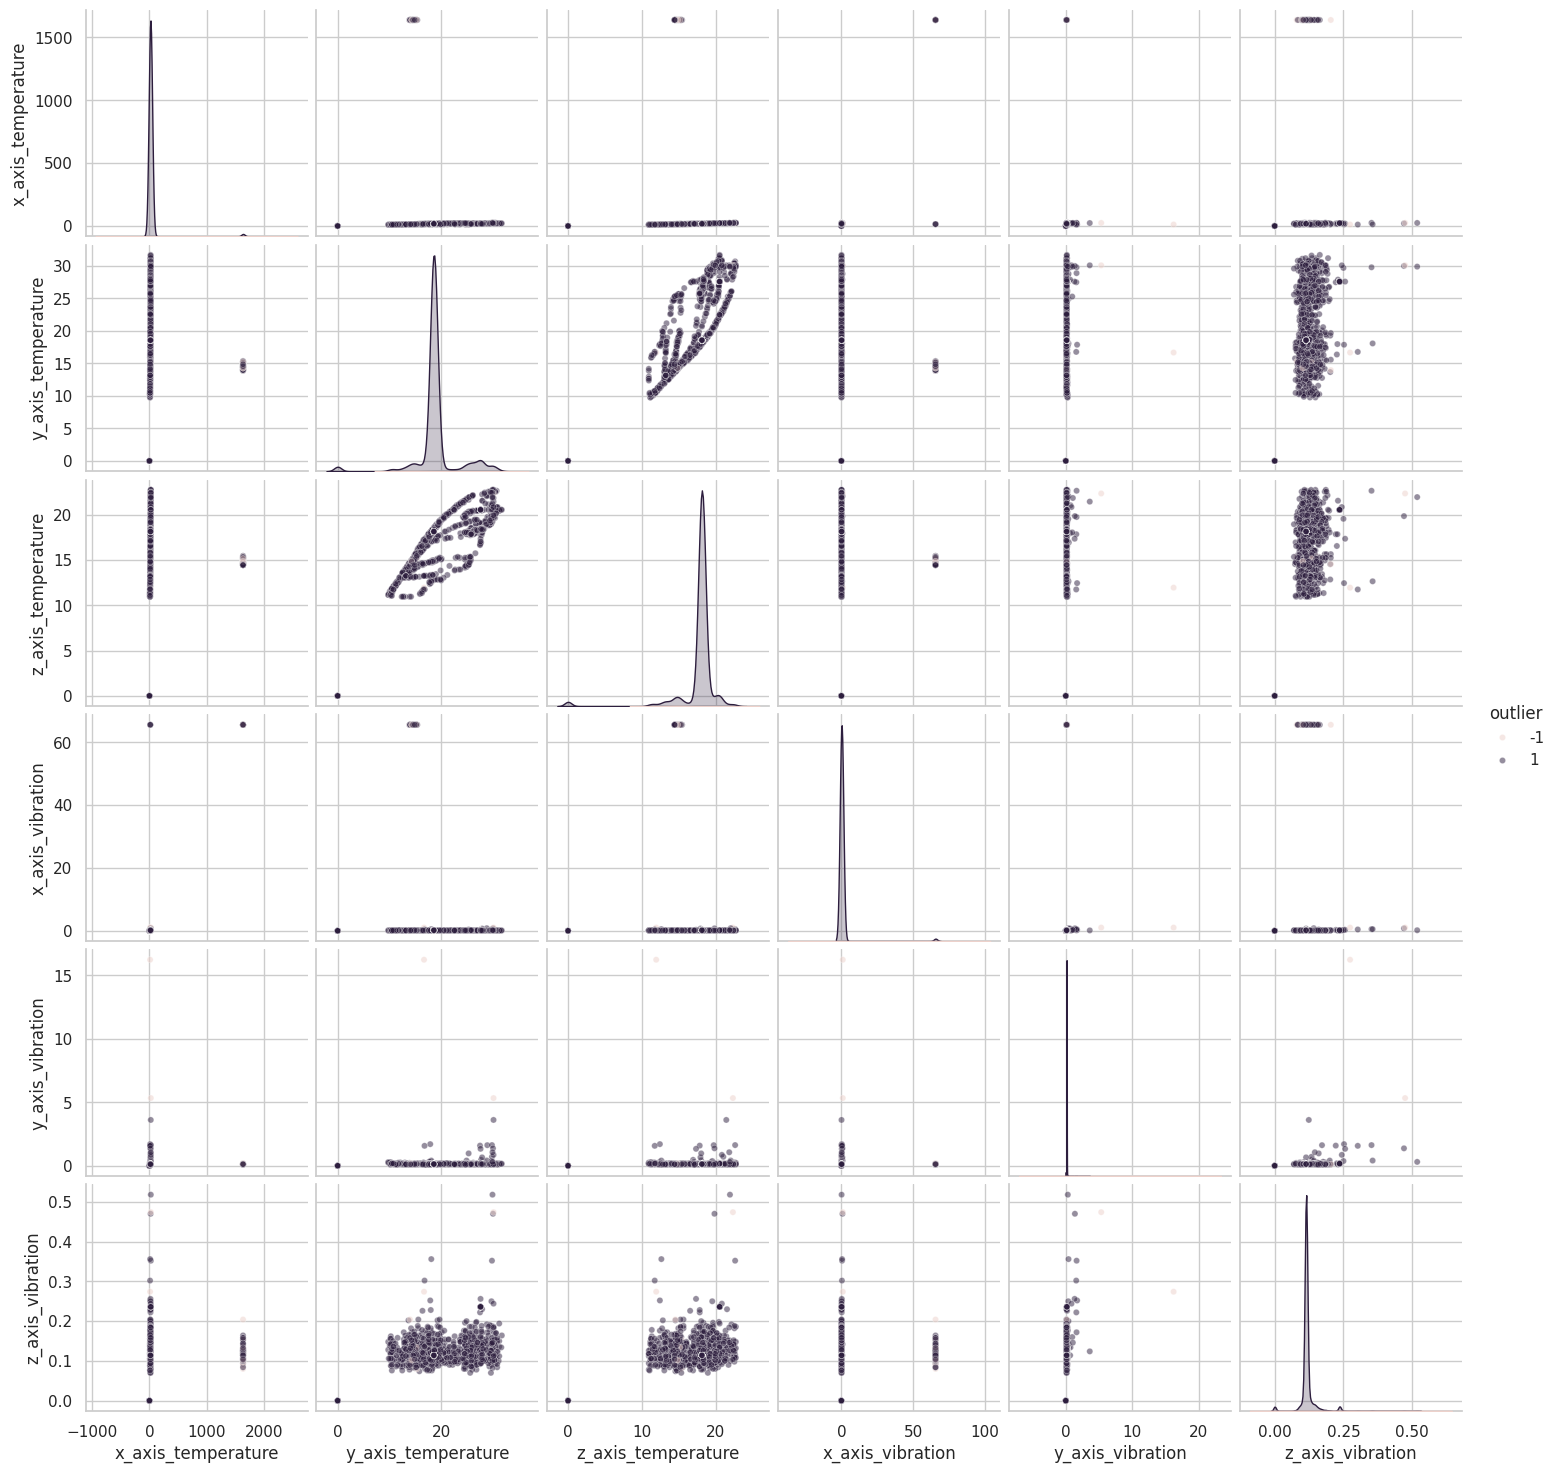

In [133]:
sns.pairplot(
    df.sample(5000),  # Without sampling it takes too long
    vars=["x_axis_temperature","y_axis_temperature","z_axis_temperature",
          "x_axis_vibration","y_axis_vibration","z_axis_vibration"],
    hue="outlier",
    plot_kws={"alpha":0.5, "s":20}
)
plt.show()


x_axis_temperature does not show any correlation with any other feature that is because it is a mesaurement of a different scale.
Also it is clear that y_axis_temperature and z_axis_temperature are highly correlated.

In [134]:
df = clean_df
df = df.drop(columns=["outlier"])
df.head()

,timestamp,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
0,08-01-19 14:41,18.55,0.100,29.05,0.092,18.85,0.128
1,08-01-19 14:41,18.55,0.100,29.25,0.092,18.85,0.132
2,08-01-19 14:41,18.65,0.112,29.05,0.114,18.85,0.132
3,08-01-19 14:41,18.65,0.112,29.25,0.114,18.85,0.110
4,08-01-19 14:41,18.65,0.162,29.05,0.100,18.85,0.110


Dataset after removing all outliers.

##2. Data Preprocessing

#Ensure the timestamp column is converted to the correct datetime format.

In [135]:
if 'timestamp' in df.columns: # To not get any errors in the second run.
        df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce and format could be added
        df = df.set_index('timestamp')
df.head(5).index.tolist()

/tmp/ipython-input-1819333241.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce and format could be added


[Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00'),
 Timestamp('2019-08-01 14:41:00')]

#Consider the trade-offs of resampling the data to a lower frequency (e.g., 15-second, 1-minute averages or 1-hour averages). Justify your choice based on whether it reduces noise without losing critical information.

In [136]:
def resampler(df, sec_size):

    resampled_df = df.resample(sec_size).mean()

    num_rows_before = len(df.index)
    num_rows_after = len(resampled_df.index)

    print("Before resample:", num_rows_before)
    print(f"After {sec_size} resample:", num_rows_after)
    print("-" * 27)

    return resampled_df

df_1h = resampler(df, '1h')
df_1m = resampler(df, '1min')
df_15s = resampler(df, '15s')
df_5m = resampler(df, '5min')
df_1M = resampler(df, '1M')
df_80s = resampler(df, '80s')
df_45s = resampler(df, '45s')

Before resample: 849553
After 1h resample: 8040
---------------------------
Before resample: 849553
After 1min resample: 482400
---------------------------
Before resample: 849553
After 15s resample: 1929597
---------------------------
Before resample: 849553
After 5min resample: 96480
---------------------------


/tmp/ipython-input-3068638435.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_df = df.resample(sec_size).mean()


Before resample: 849553
After 1M resample: 12
---------------------------
Before resample: 849553
After 80s resample: 361800
---------------------------
Before resample: 849553
After 45s resample: 643199
---------------------------


Here drawing a graph wouldn't give any meaningful insight so we continued
our analysis with comparing standart deviation values for each sampling.

In [137]:
def analyze_resampling_impact(df, *resampled_dfs):
    # *resampled_dfs: in tuple format: (df, freq_name))

    sensors = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature",
               "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]

    results = {}

    for sensor in sensors:
        try:
            original_std = df[sensor].std()

            resampled_std = {}
            variations = {}

            for resampled_df, freq_name in resampled_dfs:
                std_val = resampled_df[sensor].std()
                resampled_std[freq_name] = std_val
                variation = abs((std_val - original_std) / original_std) * 100
                variations[freq_name] = variation

            results[sensor] = {
                'original_std': original_std,
                'resampled_std': resampled_std,
                'variations': variations
            }

        except KeyError:
            print(f"Warning: {sensor} data not found.")
            continue

    return results

def print_results(results):
    # Print detailed results

    print("=" * 60)
    print("RESAMPLING ANALYSIS FOR ALL SENSORS")
    print("=" * 60)

    for sensor, data in results.items():
        print(f"\n🔹 {sensor}:")
        print(f"   Original STD: {data['original_std']:.4f}")
        for freq_name, std_val in data['resampled_std'].items():
            variation = data['variations'][freq_name]
            print(f"   {freq_name}: {std_val:.4f} (%{variation:.2f} change)")

def print_summary_statistics(results):
    # Print summary statistics

    print("\n" + "=" * 60)
    print("AGRREGATED RESULTS")
    print("=" * 60)

    # Collect all frequencies
    all_freqs = set()
    for sensor_data in results.values():
        all_freqs.update(sensor_data['variations'].keys())

    # Average change for each frequency
    avg_variations = {freq: 0 for freq in all_freqs}
    count = len(results)

    for sensor_data in results.values():
        for freq, variation in sensor_data['variations'].items():
            avg_variations[freq] += variation

    for freq in avg_variations:
        avg_variations[freq] /= count

    print(f"\nAverage change of STD:")
    for freq, avg_var in avg_variations.items():
        print(f"   {freq}: %{avg_var:.2f}")


# Example usage of functions
# Any resampled function can be sent as a parameter
results = analyze_resampling_impact(
    df,
    (df_15s, '15s'),
    (df_45s, '45s'),
    (df_1m, '1min'),
    (df_80s, '80s'),
    (df_5m, '5min'),
    (df_1h, '1h'),
    (df_1M, '1M')
)

print_results(results)

print_summary_statistics(results)

# Optimal frequency for all sensors
print("\n" + "=" * 60)
print("Optimal frequency for all sensors")
print("=" * 60)

for sensor, data in results.items():
    if data['variations']:
        best_freq = min(data['variations'].items(), key=lambda x: x[1])
        print(f"{sensor}: {best_freq[0]} (%{best_freq[1]:.2f} change)")

RESAMPLING ANALYSIS FOR ALL SENSORS

🔹 x_axis_temperature:
   Original STD: 155.7233
   15s: 142.0054 (%8.81 change)
   45s: 142.0054 (%8.81 change)
   1min: 142.0054 (%8.81 change)
   80s: 141.5715 (%9.09 change)
   5min: 139.9393 (%10.14 change)
   1h: 134.2950 (%13.76 change)
   1M: 15.5090 (%90.04 change)

🔹 y_axis_temperature:
   Original STD: 3.8967
   15s: 3.9007 (%0.10 change)
   45s: 3.9007 (%0.10 change)
   1min: 3.9007 (%0.10 change)
   80s: 3.9020 (%0.14 change)
   5min: 3.9112 (%0.37 change)
   1h: 3.9822 (%2.19 change)
   1M: 1.4128 (%63.74 change)

🔹 z_axis_temperature:
   Original STD: 2.5671
   15s: 2.5711 (%0.16 change)
   45s: 2.5711 (%0.16 change)
   1min: 2.5711 (%0.16 change)
   80s: 2.5726 (%0.22 change)
   5min: 2.5850 (%0.70 change)
   1h: 2.6864 (%4.65 change)
   1M: 0.7578 (%70.48 change)

🔹 x_axis_vibration:
   Original STD: 6.6297
   15s: 6.2737 (%5.37 change)
   45s: 6.2737 (%5.37 change)
   1min: 6.2737 (%5.37 change)
   80s: 6.2698 (%5.43 change)
   5min

By looking at these results we can conclude that optimal choice would be to resample with 1 minute.

In [138]:
df = df_1m

#Apply appropriate scaling to the sensor data. Research different scaling techniques (e.g., MinMaxScaler, StandardScaler) and determine which is most suitable for the models you plan to test.

In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_array = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

print(scaled_df.head())

                     x_axis_temperature  x_axis_vibration  y_axis_temperature  \
timestamp                                                                       
2019-01-02 00:00:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:01:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:02:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:03:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:04:00           -0.124927          -0.12759            -0.11665   

                     y_axis_vibration  z_axis_temperature  z_axis_vibration  
timestamp                                                                    
2019-01-02 00:00:00         -0.072777            0.172186         -0.122589  
2019-01-02 00:01:00         -0.072777            0.172186         -0.122589  
2019-01-02 00:02:00         -0.072777            0.172186         -0.122589  
2019-01-02 00:03:00         -0.072777     

First, outliers in the dataset were removed. Then, since the sensor features had different scales and variances, they were normalized using StandardScaler. This ensured all features have a mean of 0 and a standard deviation of 1, optimizing the performance of the anomaly detection and RUL prediction models.

In [140]:
print("Now we print standard deviation and mean values for each column to make sure it worked accordingly.")
print()
print("Standard deviation:")
print(scaled_df.std().round(2)) # We rounded these values to have a clearer output.
print()
print("Mean:")
print(scaled_df.mean().round(2))

Now we print standard deviation and mean values for each column to make sure it worked accordingly.

Standard deviation:
x_axis_temperature    1.0
x_axis_vibration      1.0
y_axis_temperature    1.0
y_axis_vibration      1.0
z_axis_temperature    1.0
z_axis_vibration      1.0
dtype: float64

Mean:
x_axis_temperature    0.0
x_axis_vibration      0.0
y_axis_temperature   -0.0
y_axis_vibration     -0.0
z_axis_temperature   -0.0
z_axis_vibration      0.0
dtype: float64


In [141]:
df = scaled_df

Now original df equals the scaled one.

##3. Feature Engineering


#Lag Features: Create features that represent the state of the machine at past time steps.

In [142]:
def add_lag_features(df, cols, lags):
    """
    DataFrame must have datetime index
    cols: for which columns lag will be added
    lags: How many steps will it be looked back
    """

    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


df = add_lag_features(df, sensor_cols, lags=[1, 2, 3])
print(display(df.head()))

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration,x_axis_temperature_lag1,x_axis_temperature_lag2,x_axis_temperature_lag3,y_axis_temperature_lag1,...,z_axis_temperature_lag3,x_axis_vibration_lag1,x_axis_vibration_lag2,x_axis_vibration_lag3,y_axis_vibration_lag1,y_axis_vibration_lag2,y_axis_vibration_lag3,z_axis_vibration_lag1,z_axis_vibration_lag2,z_axis_vibration_lag3
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 00:01:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,NaN,NaN,-0.11665,...,NaN,-0.12759,NaN,NaN,-0.072777,NaN,NaN,-0.122589,NaN,NaN
2019-01-02 00:02:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,NaN,-0.11665,...,NaN,-0.12759,-0.12759,NaN,-0.072777,-0.072777,NaN,-0.122589,-0.122589,NaN
2019-01-02 00:03:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.172186,-0.12759,-0.12759,-0.12759,-0.072777,-0.072777,-0.072777,-0.122589,-0.122589,-0.122589
2019-01-02 00:04:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.172186,-0.12759,-0.12759,-0.12759,-0.072777,-0.072777,-0.072777,-0.122589,-0.122589,-0.122589


None


Thanks to lag features, model will not only be able to see the current reading but also the trend in previous steps. Therefore increasing the learning capacity.

In [143]:
df = df.dropna()

Since we have a big dataset it is okay to lose few values.

#Rolling Window Features: Calculate statistics (e.g., moving average, standard deviation) over a defined time window to capture the machine's recent behavior and volatility.

In [144]:
def add_rolling_features(df, window_size=3, period =3):
    """
    DataFrame'e rolling mean ve rolling std kolonlarını ekler.

    Args:
        df (pd.DataFrame): Orijinal DataFrame
        window_size (int): Rolling window boyutu

    Returns:
        pd.DataFrame: Yeni kolonlar eklenmiş DataFrame
    """
    new_cols = {}

    for col in df.columns:
        if df[col].dtype in [float, int]:
            new_cols[f"{col}_roll_mean"] = df[col].rolling(window=window_size, min_periods = period).mean()
            new_cols[f"{col}_roll_std"] = df[col].rolling(window=window_size, min_periods = period).std()

    return pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(add_rolling_features(df, 3, 3))

                     x_axis_temperature  x_axis_vibration  y_axis_temperature  \
timestamp                                                                       
2019-01-02 00:03:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:04:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:05:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:06:00           -0.124927          -0.12759            -0.11665   
2019-01-02 00:07:00           -0.124927          -0.12759            -0.11665   
...                                 ...               ...                 ...   
2019-12-02 23:55:00           -0.124927          -0.12759            -0.11665   
2019-12-02 23:56:00           -0.124927          -0.12759            -0.11665   
2019-12-02 23:57:00           -0.124927          -0.12759            -0.11665   
2019-12-02 23:58:00           -0.124927          -0.12759            -0.11665   
2019-12-02 23:59:00         

In [145]:
df  = add_rolling_features(df, 3, 3)

#Aggregate Features: Engineer features that summarize the overall state of the machine, such as the average temperature or the magnitude of the vibration vector.


In [146]:
from sklearn.cluster import FeatureAgglomeration

df['avg_temperature'] = df[['x_axis_temperature', 'y_axis_temperature', 'z_axis_temperature']].mean(axis=1)
df['vibration_rms'] = np.sqrt((df['x_axis_vibration']**2 + df['y_axis_vibration']**2 + df['z_axis_vibration']**2) / 3) # 3 ortalam almak için.
df['temperature_range'] = abs(df[['x_axis_temperature', 'y_axis_temperature', 'z_axis_temperature']].max(axis=1) - df[['x_axis_temperature', 'y_axis_temperature', 'z_axis_temperature']].min(axis = 1))
print(display(df.head()))

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration,x_axis_temperature_lag1,x_axis_temperature_lag2,x_axis_temperature_lag3,y_axis_temperature_lag1,...,y_axis_vibration_lag3_roll_std,z_axis_vibration_lag1_roll_mean,z_axis_vibration_lag1_roll_std,z_axis_vibration_lag2_roll_mean,z_axis_vibration_lag2_roll_std,z_axis_vibration_lag3_roll_mean,z_axis_vibration_lag3_roll_std,avg_temperature,vibration_rms,temperature_range
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:03:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.02313,0.110459,0.297113
2019-01-02 00:04:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.02313,0.110459,0.297113
2019-01-02 00:05:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113
2019-01-02 00:06:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113
2019-01-02 00:07:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113


None


##4. Unsupervised Anomaly Detection

#Research and implement at least two different unsupervised anomaly detection algorithms on your rich feature set. Your goal is to find the method that most logically identifies what appear to be failure states.

Applying Isolation Forest

In [147]:
clf = IsolationForest(random_state=0)

# 1 = normal, -1 = anomaly
clf.fit(df)

anomaly_labels = clf.predict(df)
df['IF_anomaly'] = anomaly_labels

In [148]:
print(display(df.head()))

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration,x_axis_temperature_lag1,x_axis_temperature_lag2,x_axis_temperature_lag3,y_axis_temperature_lag1,...,z_axis_vibration_lag1_roll_mean,z_axis_vibration_lag1_roll_std,z_axis_vibration_lag2_roll_mean,z_axis_vibration_lag2_roll_std,z_axis_vibration_lag3_roll_mean,z_axis_vibration_lag3_roll_std,avg_temperature,vibration_rms,temperature_range,IF_anomaly
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:03:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.02313,0.110459,0.297113,1
2019-01-02 00:04:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.02313,0.110459,0.297113,1
2019-01-02 00:05:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1
2019-01-02 00:06:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1
2019-01-02 00:07:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,-0.122589,0.0,-0.122589,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1


None


Visualizations of outliers on some certain columns.

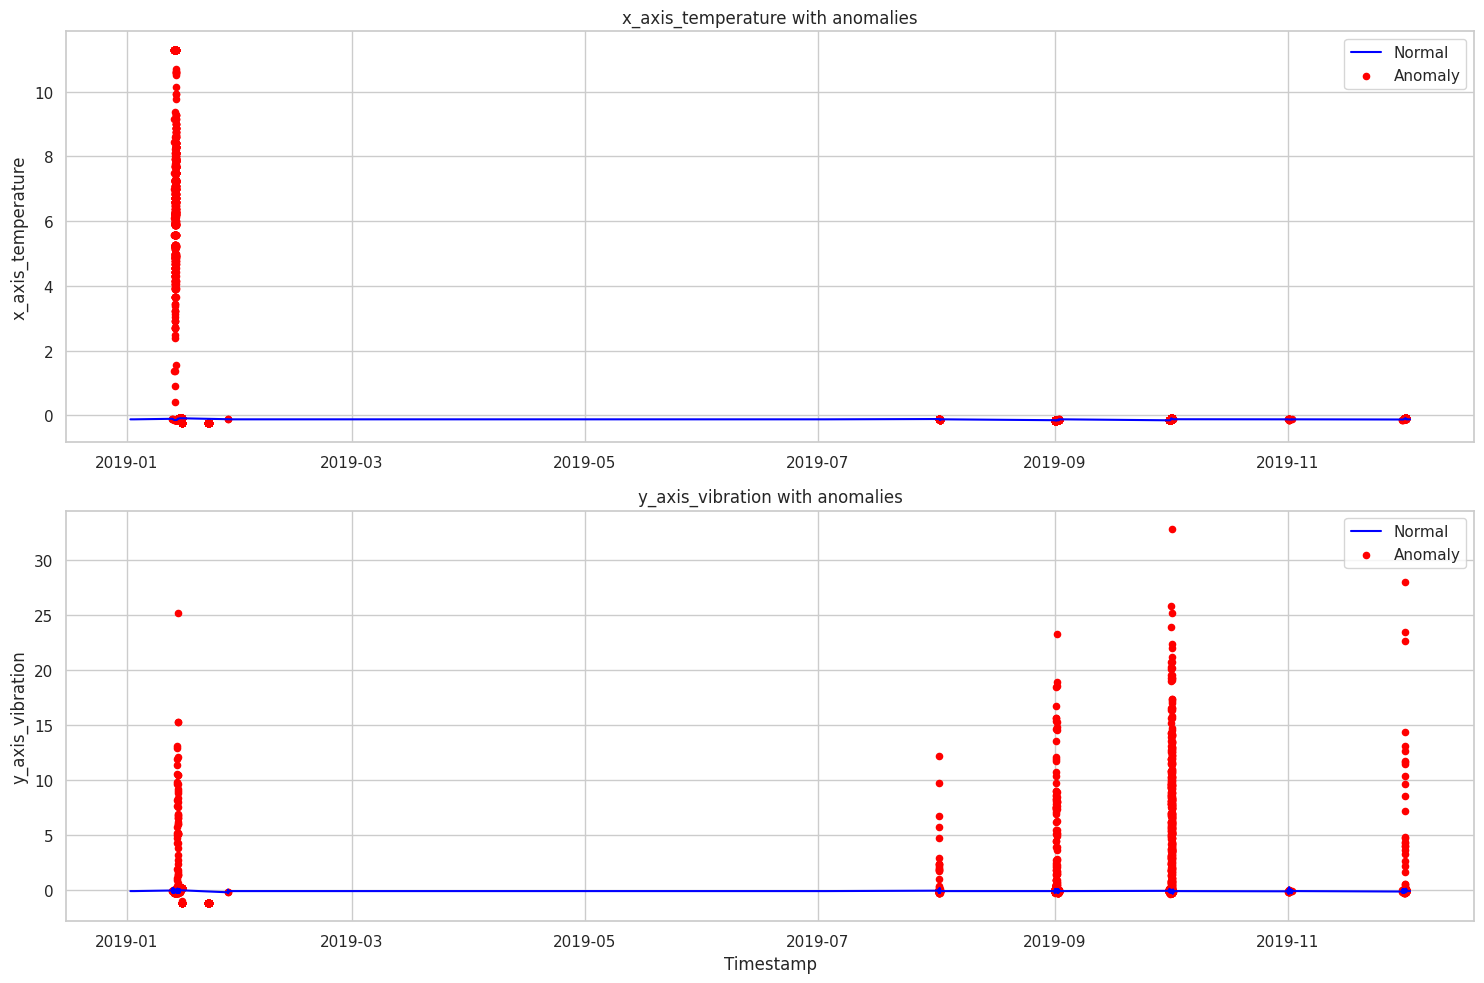

In [149]:
sensor1 = 'x_axis_temperature'
sensor2 = 'y_axis_vibration'

normal = df[df['IF_anomaly'] == 1]
anomalies = df[df['IF_anomaly'] == -1]

plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.plot(normal.index, normal[sensor1], label='Normal', color='blue')
plt.scatter(anomalies.index, anomalies[sensor1], color='red', label='Anomaly', s=20)
plt.title(f'{sensor1} with anomalies')
plt.ylabel(sensor1)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(normal.index, normal[sensor2], label='Normal', color='blue')
plt.scatter(anomalies.index, anomalies[sensor2], color='red', label='Anomaly', s=20)
plt.title(f'{sensor2} with anomalies')
plt.xlabel('Timestamp')
plt.ylabel(sensor2)
plt.legend()

plt.tight_layout()
plt.show()

Applying Autoencoder

In [150]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [151]:
# Autoencoder architecture
input_dim = len(sensor_cols)
encoding_dim = 10

In [152]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

In [153]:
# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

In [154]:
# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

In [155]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [156]:
# Train the autoencoder
autoencoder_columns = df[['x_axis_temperature', 'y_axis_temperature', 'z_axis_temperature', 'x_axis_vibration', 'y_axis_vibration', 'z_axis_vibration']]
autoencoder.fit(autoencoder_columns, autoencoder_columns, epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1670
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8809
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8155
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8265
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7998
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7919
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7755
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7706
Epoch 9/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7717
Epoch 10/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7794
Epoch 11/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7783
Epoch 12/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7864
Epoch 13/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7786
Epoch 14/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7993
Epoch 15/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [157]:
encoder = Model(inputs=input_layer, outputs=encoded)

In [158]:
latent_features = encoder.predict(autoencoder_columns)
print("Latent Features Shape:", latent_features.shape)

1330/1330 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Latent Features Shape: (42556, 10)


In [159]:
# Reconstruct
X = autoencoder_columns

X_pred = autoencoder.predict(X)

1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step


In [160]:
# Computing reconstruction error
reconstruction_error = np.mean(np.square(X - X_pred), axis=1)

In [161]:
# anomaly threshold
threshold = np.percentile(reconstruction_error, 95)  # top 5% errors
df["AE_error"] = reconstruction_error
df["AE_anomaly"] = (reconstruction_error > threshold).astype(int)  # 1 = anomaly, 0 = normal

print(f"Autoencoder marked {df['AE_anomaly'].sum()} anomalies")

Autoencoder marked 1665 anomalies


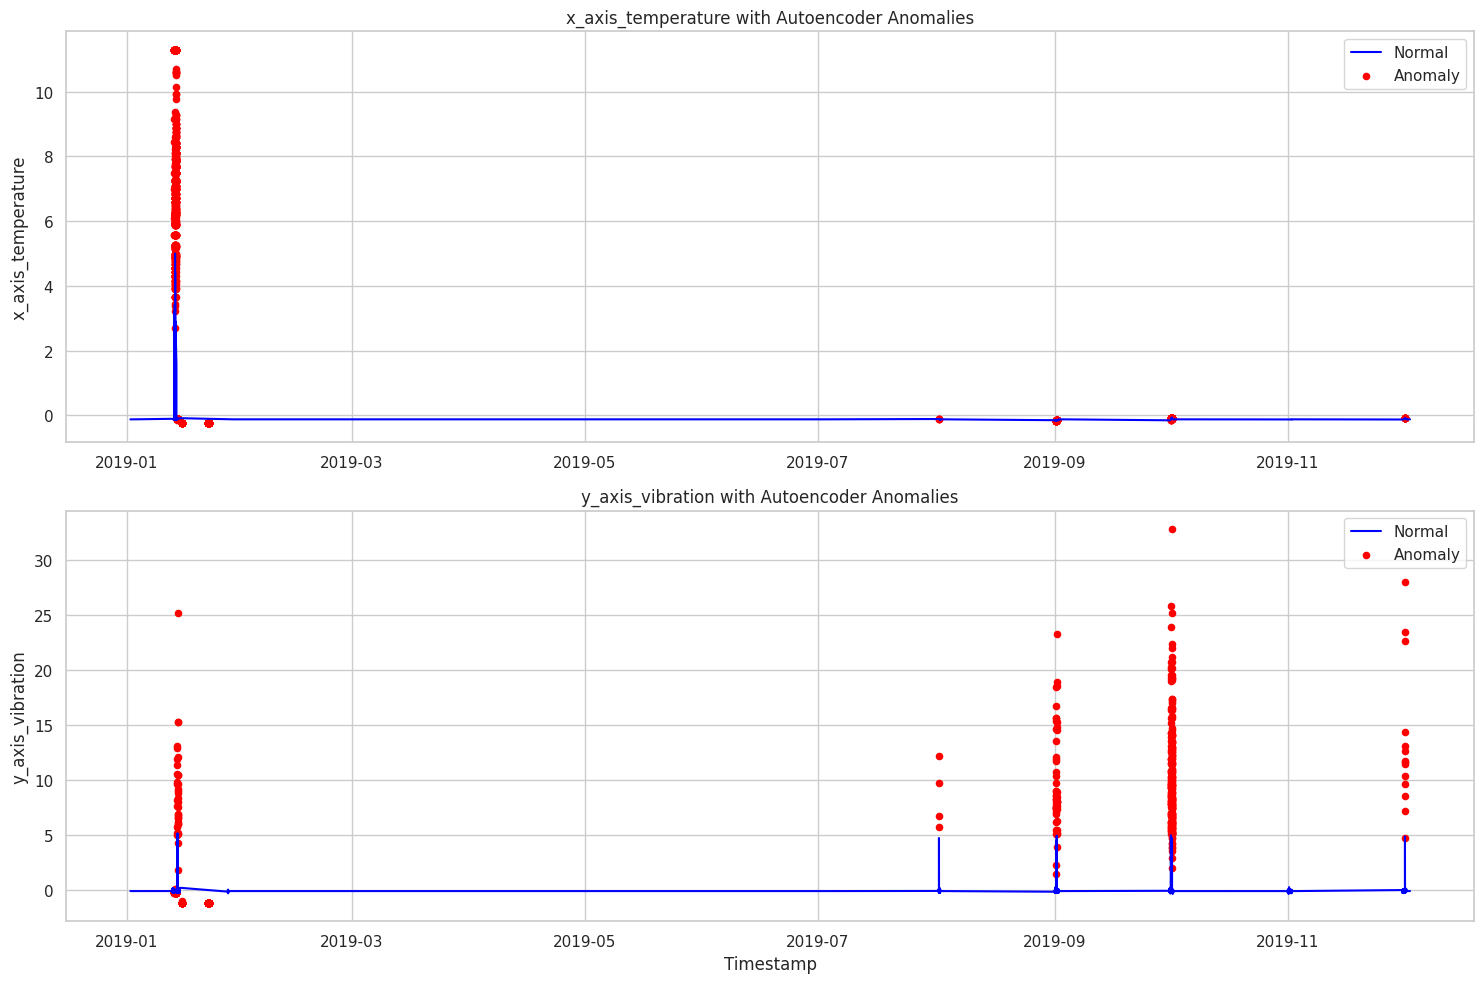

In [162]:
# Visualize
sensor1 = "x_axis_temperature"
sensor2 = "y_axis_vibration"

normal = df[df["AE_anomaly"] == 0]
anomalies = df[df["AE_anomaly"] == 1]

plt.figure(figsize=(15,10))


plt.subplot(2, 1, 1)
plt.plot(normal.index, normal[sensor1], label="Normal", color="blue")
plt.scatter(anomalies.index, anomalies[sensor1], color="red", label="Anomaly", s=20)
plt.title(f"{sensor1} with Autoencoder Anomalies")
plt.ylabel(sensor1)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(normal.index, normal[sensor2], label="Normal", color="blue")
plt.scatter(anomalies.index, anomalies[sensor2], color="red", label="Anomaly", s=20)
plt.title(f"{sensor2} with Autoencoder Anomalies")
plt.xlabel("Timestamp")
plt.ylabel(sensor2)
plt.legend()

plt.tight_layout()
plt.show()

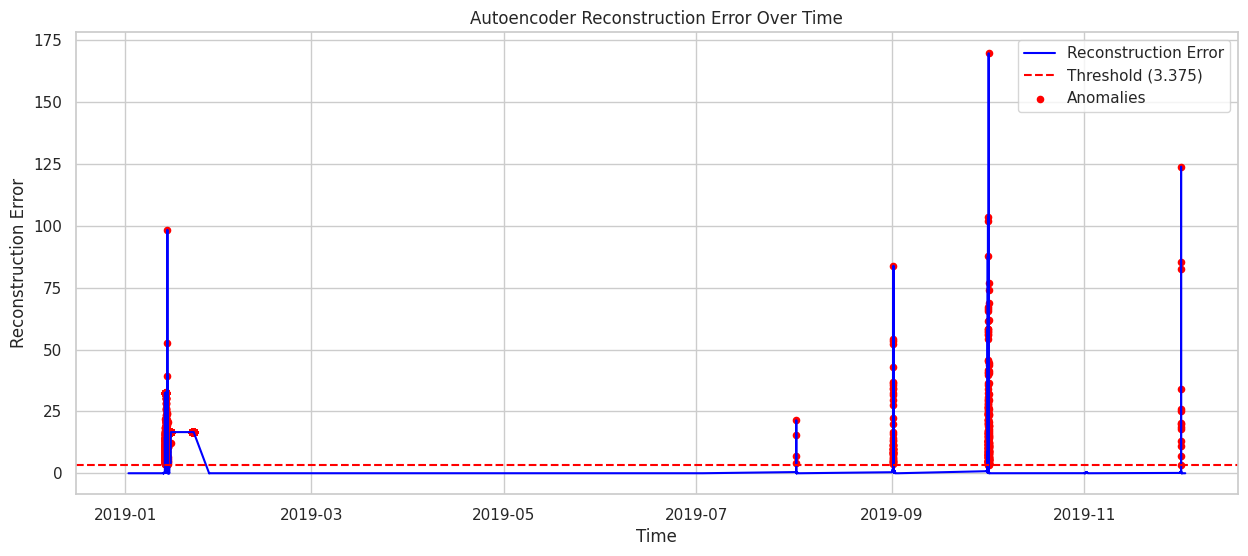

In [163]:
# threshold value
threshold = df["AE_error"].quantile(0.95)

plt.figure(figsize=(15,6))
plt.plot(df.index, df["AE_error"], label="Reconstruction Error", color="blue")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.3f})")

anomalies = df[df["AE_error"] > threshold]
plt.scatter(anomalies.index, anomalies["AE_error"], color="red", s=20, label="Anomalies")

plt.title("Autoencoder Reconstruction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


Confirmed anomalies (AE ∩ IF): 1665


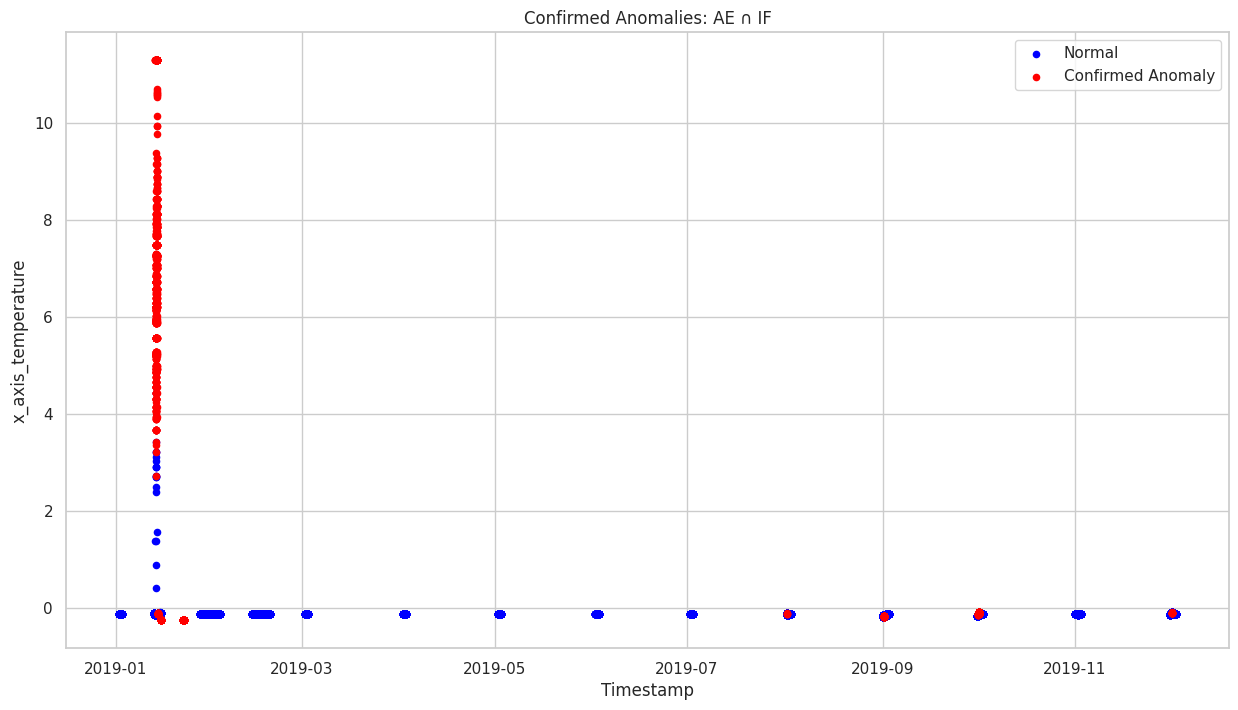

In [164]:
# 0 = normal, 1 = confirmed anomaly (AE ∩ IF)
df['anomaly'] = 0

# Only keep confirmed anomalies (intersection of AE and IF)
confirmed_mask = (df['AE_anomaly'] == 1) & (df['IF_anomaly'] == -1)
df.loc[confirmed_mask, 'anomaly'] = 1

# Count
print("Confirmed anomalies (AE ∩ IF):", df['anomaly'].sum())

# Visualize
plt.figure(figsize=(15,8))
colors = {0:'blue', 1:'red'}
labels = {0:'Normal', 1:'Confirmed Anomaly'}

for label in [0,1]:
    subset = df[df['anomaly'] == label]
    plt.scatter(subset.index, subset['x_axis_temperature'],
                color=colors[label], label=labels[label], s=20)

plt.title("Confirmed Anomalies: AE ∩ IF")
plt.xlabel("Timestamp")
plt.ylabel("x_axis_temperature")
plt.legend()
plt.show()


In [165]:
df.head()

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration,x_axis_temperature_lag1,x_axis_temperature_lag2,x_axis_temperature_lag3,y_axis_temperature_lag1,...,z_axis_vibration_lag2_roll_std,z_axis_vibration_lag3_roll_mean,z_axis_vibration_lag3_roll_std,avg_temperature,vibration_rms,temperature_range,IF_anomaly,AE_error,AE_anomaly,anomaly
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:03:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,-0.02313,0.110459,0.297113,1,0.011003,0,0
2019-01-02 00:04:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,NaN,NaN,NaN,-0.02313,0.110459,0.297113,1,0.011003,0,0
2019-01-02 00:05:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1,0.011003,0,0
2019-01-02 00:06:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1,0.011003,0,0
2019-01-02 00:07:00,-0.124927,-0.12759,-0.11665,-0.072777,0.172186,-0.122589,-0.124927,-0.124927,-0.124927,-0.11665,...,0.0,-0.122589,0.0,-0.02313,0.110459,0.297113,1,0.011003,0,0


In [166]:
if 'IF_anomaly' in df.columns:
    if 'AE_error' in df.columns:
        if  'AE_anomaly' in df.columns:
            df = df.drop(columns=['IF_anomaly', 'AE_error', 'AE_anomaly'])

In the end it was decided to mark the intersection of both models as the final error and mark the ones only autoencoder marked as suspected errors.

##5. Remaining Useful Life (RUL) Modeling and Training

#Create the Target Variable: For each "normal" data point, calculate the time (in days or weeks) until the next anomaly event occurs. This will be your target variable (y).

In [170]:
df = df.sort_index()

next_anomaly_time = df.index.to_series().where(df['anomaly'] == 1).ffill(limit=None)
next_anomaly_time = df.index.to_series().where(df['anomaly'] == 1).bfill()

# Time difference in days
df['RUL_days'] = (next_anomaly_time - df.index.to_series()).dt.total_seconds() / (24*3600)  # convert seconds to days

df.loc[df['anomaly'] == 1, 'RUL_days'] = 0

# Keeping only normal points for regression
rul_df = df[df['anomaly'] == 0].copy()

print(display(rul_df[['RUL_days']].head()))

,RUL_days
timestamp,
2019-01-02 00:03:00,11.534028
2019-01-02 00:04:00,11.533333
2019-01-02 00:05:00,11.532639
2019-01-02 00:06:00,11.531944
2019-01-02 00:07:00,11.531250


None


#Select and Train a Model: Research and select a powerful regression model capable of handling the complexity of your feature set.

XGBoost was selected due to its effectiveness in modeling complex patterns in sensor data and its suitability for accurate Remaining Useful Life (RUL) prediction.

In [171]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [172]:
# Drop rows with missing or infinite target values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['RUL_days'])

In [176]:
X = df.drop(columns=['anomaly', 'RUL_days'])
y = df['RUL_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [177]:
params = {
    'objective': 'reg:squarederror',  # regression
    'max_depth': 4,
    'eta': 0.3,
    'seed': 42
}

In [178]:
model = xgb.train(params, dtrain, num_boost_round=50)

predictions = model.predict(dtest)

##6. Hyperparameter Tuning

#Use a systematic approach (e.g., RandomizedSearchCV, GridSearchCV, or a more advanced Bayesian optimization library) to find the best hyperparameters for your model.


In [179]:
!pip install scikit-optimize

In [180]:
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [181]:
param_space = {
    'max_depth': (3, 10),        # tree depth
    'learning_rate': (0.01, 0.5, 'log-uniform'),  # eta
    'n_estimators': (50, 500),   # number of trees
    'subsample': (0.5, 1.0),     # row sampling
    'colsample_bytree': (0.5, 1.0),  # column sampling
    'gamma': (0, 5)              # min loss reduction
}

In [182]:
tscv = TimeSeriesSplit(n_splits=3)

In [183]:
opt = BayesSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist'
    ),
    search_spaces=param_space,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [184]:
# Run optimization
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
              n_iter=10, n_jobs=-1, scoring='neg_mean_absolute_error',
              search_spaces={'colsample_bytree': (0.5, 1.0), 'gamma': (0, 5),
                             'learning_rate': (0.01, 0.5, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'subsample': (0.5, 1.0)},
              verbose=1)

In [185]:
# Best model parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)

Best Parameters: OrderedDict({'colsample_bytree': 0.8945268591153277, 'gamma': 3, 'learning_rate': 0.047256850147800324, 'max_depth': 7, 'n_estimators': 469, 'subsample': 0.854211894851932})


In [186]:
# Predict on test set
y_pred = opt.predict(X_test)

##7. Test and Evaluation

In [187]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.3f} days")

Test MAE: 45.196 days


In [188]:
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000

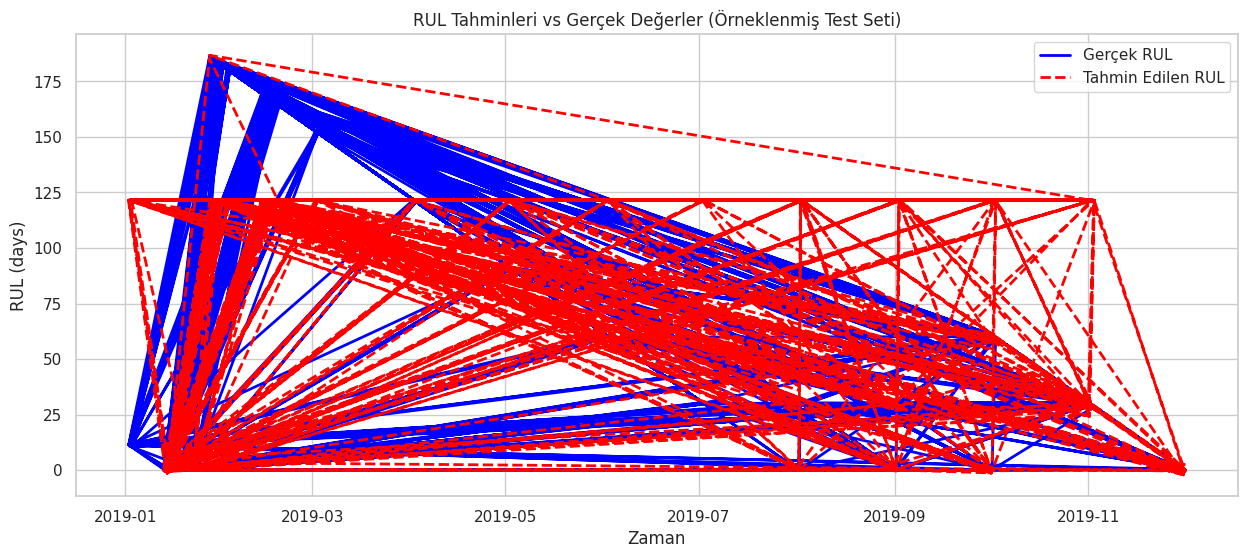

In [189]:
import matplotlib.pyplot as plt

# Test setinden örnekleme: her 10. noktayı al
sample_step = 10
plt.figure(figsize=(15,6))
plt.plot(y_test.index[::sample_step], y_test[::sample_step], label='Gerçek RUL', color='blue', linewidth=2)
plt.plot(y_test.index[::sample_step], y_pred[::sample_step], label='Tahmin Edilen RUL', color='red', linestyle='--', linewidth=2)

plt.title("RUL Tahminleri vs Gerçek Değerler (Örneklenmiş Test Seti)")
plt.xlabel("Zaman")
plt.ylabel("RUL (days)")
plt.legend()
plt.grid(True)
plt.show()